# Configuration Settings

Import necessary packages, classes, and functions.

In [1]:
import numpy as np
import scipy

import torch
import geoopt

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

import pickle

from utils import MDADataset, ManifoldEmbedding, sample_negative_associations, unfold_association_matrix, process_batch

Set the device to GPU if possible.

In [2]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

Fixing the random seed for reproducibility.

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Set double precision for the numerical stability of the Lorentz manifold.

In [4]:
torch.set_default_dtype(torch.float64)

Ignore warnings.

In [5]:
import warnings
warnings.filterwarnings('ignore')

Set the cross-validation configuration.

In [20]:
num_repeats = 10
num_splits = 5
negative_sample_ratio = 5

num_epochs = 32
batch_size = 256
def latent_dim_to_learning_rate(latent_dim):
    return 0.001/(np.log2(latent_dim))

config_name = "CV_" + str(num_repeats) + "repeats_" + str(num_splits) + "splits_" + str(negative_sample_ratio) + "negatives_" + str(num_epochs) + "epochs_" + str(batch_size) + "batchsize_" + "001log2latlearningrate"

Load the association matrix.

In [7]:
association_matrix = scipy.sparse.load_npz("data/associations.npz")

# Repeated Cross-Validation

Define the used models and latent dimensions.

In [8]:
models = [
    {"name": "Euclidean", 
     "manifold": geoopt.manifolds.Euclidean(ndim = 1),
     "ambient_dimension": 0},
    {"name": "Hyperboloid", 
     "manifold": geoopt.manifolds.Lorentz(k = 1.0, learnable=False),
     "ambient_dimension": 1},
]

latent_dimensions = [2**i for i in range(1,13)]

Perform the repeated cross-validation and store the AUC metrics for each repeat, fold, and epoch.

In [9]:
results = {}
for model in models:
    results[model["name"]] = {}
    for latent_dim in latent_dimensions:
        results[model["name"]][str(latent_dim)] = {}
        for metric in ["ROCAUC", "PRAUC"]:
            results[model["name"]][str(latent_dim)][metric] = np.zeros((num_repeats, num_splits, num_epochs))

skf = KFold(n_splits=num_splits, random_state=None, shuffle = True)
for repeat in range(num_repeats):
    print("Repeat: " + str(repeat+1) + "/" + str(num_repeats))

    sampled_association_matrix = sample_negative_associations(association_matrix, negative_sample_ratio)
    num_metabolites, num_diseases = sampled_association_matrix.shape
    metabolites, diseases, associations = unfold_association_matrix(sampled_association_matrix)

    for split, (train_index, test_index) in enumerate(skf.split(associations)):
        print("\tSplit: " + str(split+1) + "/" + str(num_splits))

        assert (np.unique(metabolites[train_index])).shape[0] == num_metabolites
        assert (np.unique(diseases[train_index])).shape[0] == num_diseases

        train_dataset = MDADataset(metabolites[train_index], diseases[train_index], associations[train_index])
        test_dataset = MDADataset(metabolites[test_index], diseases[test_index], associations[test_index])
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=False, shuffle = True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, num_workers=0, pin_memory=False, shuffle = False)

        for model in models:
            for latent_dim in latent_dimensions:
                learning_rate = latent_dim_to_learning_rate(latent_dim)
                
                metabolite_embedding_module = ManifoldEmbedding(num_metabolites, latent_dim + model["ambient_dimension"], model["manifold"]).to(device)
                disease_embedding_module = ManifoldEmbedding(num_diseases, latent_dim + model["ambient_dimension"], model["manifold"]).to(device)

                optimizer = geoopt.optim.RiemannianAdam(params=list(metabolite_embedding_module.parameters())+list(disease_embedding_module.parameters()), lr=learning_rate, stabilize=1)

                for epoch in range(num_epochs):

                    metabolite_embedding_module.train()
                    disease_embedding_module.train()
                    for batch in train_dataloader:
                        optimizer.zero_grad()
                        predicted_association, true_association = process_batch(batch, model["manifold"], device, metabolite_embedding_module, disease_embedding_module)
                        loss = torch.nn.BCELoss(weight=torch.where(true_association<0.5, 1, negative_sample_ratio), reduction="mean")(predicted_association, true_association) 
                        loss.backward()
                        optimizer.step()
                    
                    metabolite_embedding_module.eval()
                    disease_embedding_module.eval()
                    y_preds, y_true = [], []
                    with torch.no_grad():
                        for batch in test_dataloader:
                            predicted_association, true_association = process_batch(batch, model["manifold"], device, metabolite_embedding_module, disease_embedding_module)
                            y_preds.append(predicted_association.detach().cpu().numpy())
                            y_true.append(true_association.detach().cpu().numpy())
                        y_preds =  np.concatenate(y_preds)
                        y_true =  np.concatenate(y_true)

                        results[model["name"]][str(latent_dim)]["ROCAUC"][repeat,split,epoch] = roc_auc_score(y_true = y_true, y_score = y_preds)
                        precision, recall, _ = precision_recall_curve(y_true = y_true, probas_pred = y_preds)
                        results[model["name"]][str(latent_dim)]["PRAUC"][repeat,split,epoch]  = auc(recall, precision)

Repeat: 1/10
	Split: 1/5


	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5
Repeat: 2/10
	Split: 1/5
	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5
Repeat: 3/10
	Split: 1/5
	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5
Repeat: 4/10
	Split: 1/5
	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5
Repeat: 5/10
	Split: 1/5
	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5
Repeat: 6/10
	Split: 1/5
	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5
Repeat: 7/10
	Split: 1/5
	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5
Repeat: 8/10
	Split: 1/5
	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5
Repeat: 9/10
	Split: 1/5
	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5
Repeat: 10/10
	Split: 1/5
	Split: 2/5
	Split: 3/5
	Split: 4/5
	Split: 5/5


Save the results.

In [10]:
with open('results/' + config_name + '.pkl', 'wb') as fp:
        pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Result Visualization

Import necessary plotting libraries.

In [11]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Load the results into a data frame.

In [21]:
with open('results/' + config_name + '.pkl', 'rb') as fp:
    results = pickle.load(fp)

df_results = pd.DataFrame(columns = ["Model", "Latent dimension", "Metric", "Epoch", "value"])
for model, model_dict in results.items():
    for latent_dim, latent_dict in model_dict.items():
        for metric, metrics in latent_dict.items():
            for epoch in range(metrics.shape[-1]):
                for value in metrics[:,:,epoch].flatten():
                    df_results.loc[len(df_results.index)] = [model, int(latent_dim), metric, epoch+1, value] 

Create and save Figure 1.a: Plot the cross-validation results using a separate box plot for each manifold type and latent dimension.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


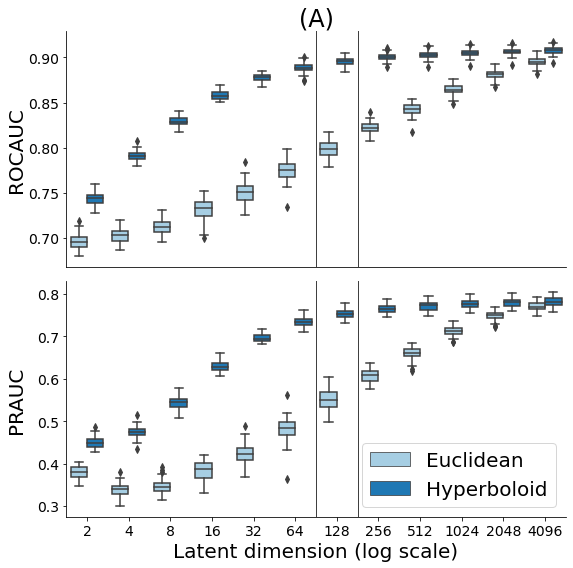

In [22]:
metrics = ["ROCAUC", "PRAUC"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*4), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]

    sns.boxplot(data = df_results[(df_results["Metric"] == metric) & (df_results["Epoch"] == num_epochs)], 
                x = "Latent dimension", y = "value", hue = "Model", palette = "Paired", saturation=1.00, ax=ax)
    ax.axvline(5.5, color = "black", alpha = 0.75, linewidth=1.00)
    ax.axvline(6.5, color = "black", alpha = 0.75, linewidth=1.00)

    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    if i == 0:
        ax.set_title("(A)", fontsize=24)
        ax.get_legend().remove()
    else:
        ax.legend(fontsize="20", loc ="lower right")

    if i == len(metrics) - 1:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
            tick.label.set_rotation('horizontal')
        ax.set_xlabel("Latent dimension (log scale)", fontsize=20)
    else:
        ax.set_xticks([])
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    ax.set_ylabel(metric, fontsize=20)
    ax.yaxis.set_label_coords(-0.08, 0.5)

plt.tight_layout()
plt.savefig('results/Fig1a.jpg', dpi = 300)
plt.savefig('results/Fig1a.eps', dpi = 300)
plt.show()

Create and save Figure 1.b: Plot the learning curve of models with a given latent dimension.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


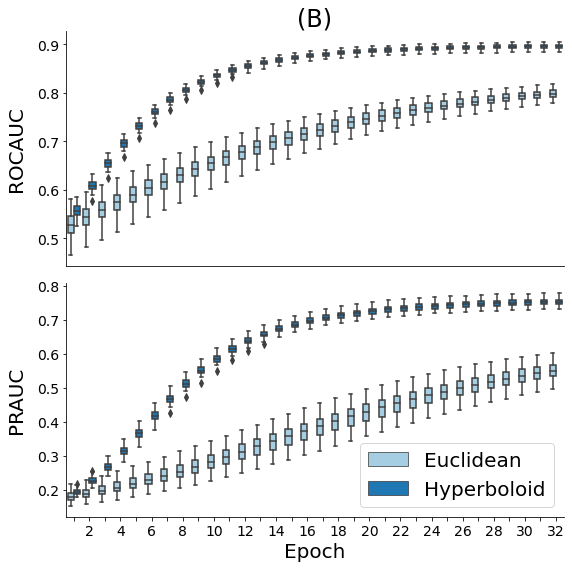

In [23]:
latent_dim = 128
metrics = ["ROCAUC", "PRAUC"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*4), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]

    sns.boxplot(data = df_results[(df_results["Metric"] == metric) & (df_results["Latent dimension"] == latent_dim)], 
                x = "Epoch", y = "value", hue = "Model", palette = "Paired", saturation=1.00, ax=ax)
    
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    if i == 0:
        ax.set_title("(B)", fontsize=24)
        ax.get_legend().remove()
    else:
        ax.legend(fontsize="20", loc ="lower right")

    if i == len(metrics) - 1:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
            tick.label.set_rotation('horizontal')
        for label in ax.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
        ax.set_xlabel("Epoch", fontsize=20)
    else:
        ax.set_xticks([])
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    ax.set_ylabel(metric, fontsize=20)
    ax.yaxis.set_label_coords(-0.08, 0.5)

plt.tight_layout()
plt.savefig('results/Fig1b.jpg', dpi = 300)
plt.savefig('results/Fig1b.eps', dpi = 300)
plt.show()